<a href="https://www.kaggle.com/code/chandlertimm/face-mask-detection-with-empirical-attention?scriptVersionId=90787027" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import torch, torchvision
import glob
import os
import numpy as np
import cv2
import random
import itertools
import pandas as pd
#from tqdm import tqdm
import urllib
import json
import PIL.Image as Image
import shutil
from os.path import exists
from tqdm.auto import  tqdm
import imagehash


anno_path = "/kaggle/input/face-mask-detection/annotations"
image_path = "/kaggle/input/face-mask-detection/images/"

# View the dataset

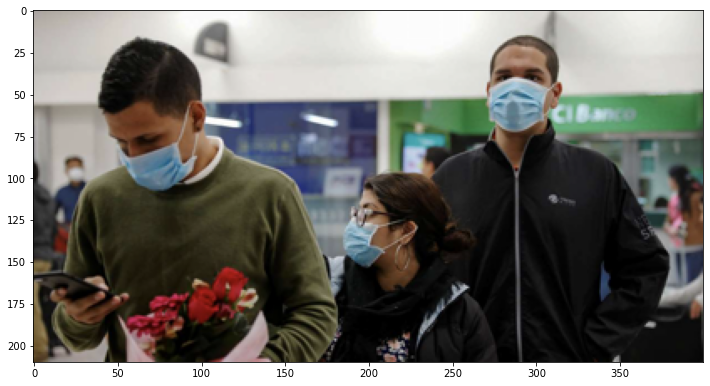

In [2]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('../input/face-mask-detection/images/maksssksksss167.png')

img = cv2.cvtColor(img,  cv2.COLOR_RGB2BGR)

plt.figure(figsize=(12,12))
plt.imshow(img)

In [3]:
!pip install xmltodict

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
xml_names = []
img_names = []

xml_names = [ f for f in os.listdir(anno_path) if os.path.isfile(os.path.join(anno_path,f)) ]
img_names = [ f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path,f)) ]

# xml_names = sorted(xml_names)
# img_names = sorted(img_names)
# print(xml_names[0:3])
# print(img_names[0:3])

In [5]:
from collections import Counter
import xmltodict

path_annotations="../input/face-mask-detection/annotations/" 
listing=[]
for i in img_names[:]:
    with open(path_annotations+i[:-4]+".xml") as fd:
        doc=xmltodict.parse(fd.read())
    temp=doc["annotation"]["object"]
    if type(temp)==list:
        for i in range(len(temp)):
            listing.append(temp[i]["name"])
    else:
        listing.append(temp["name"])
        

Items = Counter(listing).keys()
values = Counter(listing).values()

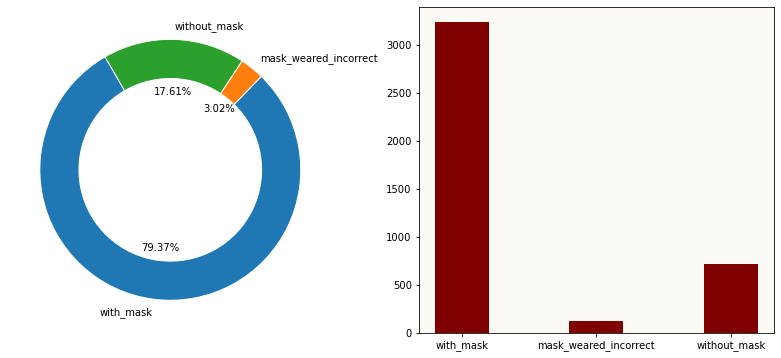

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(14,6))
background_color = '#faf9f4'
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color) 
ax1.pie(values,wedgeprops=dict(width=0.3, edgecolor='w') ,
        labels=Items, radius=1, startangle = 120, autopct='%1.2f%%')

ax2 = plt.bar(Items, list(values),
              color ='maroon',width = 0.4)

plt.show()

# Find duplicate images

In [7]:
funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
image_ids = []
hashes = []

for path in tqdm(glob.glob(image_path + '*.png' )):
    image = Image.open(path)
    image_id = os.path.basename(path)
    image_ids.append(image_id)
    hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))

hashes_all = np.array(hashes)

In [8]:
hashes_all = torch.Tensor(hashes_all.astype(int)).cuda()

In [9]:
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

In [10]:
indices1 = np.where(sims > 0.9)
indices2 = np.where(indices1[0] != indices1[1])
image_ids1 = [image_ids[i] for i in indices1[0][indices2]]
image_ids2 = [image_ids[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([image_id1,image_id2])):True for image_id1, image_id2 in zip(image_ids1, image_ids2)}

print('found %d duplicates' % len(dups))

found 23 duplicates


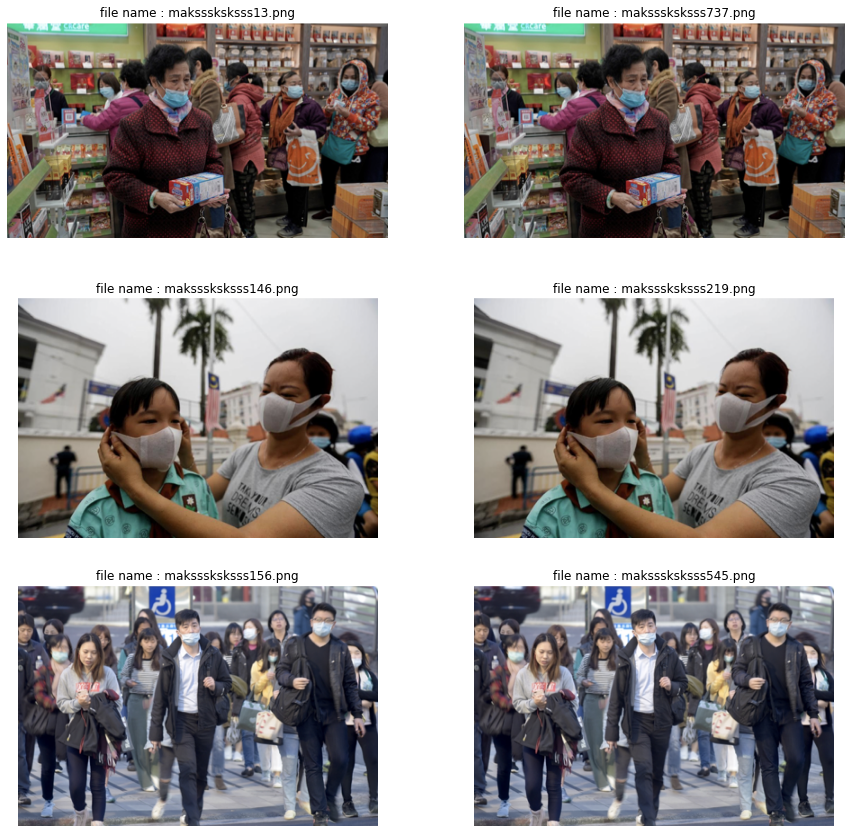

In [11]:
duplicate_image_ids = sorted(list(dups))

fig, axs = plt.subplots(3, 2, figsize=(15,15))

for row in range(3):
        for col in range(2):
            img_id = duplicate_image_ids[row][col]
            img = Image.open(image_path + img_id)
            #label =str(train.loc[train['image_id'] == img_id].label.values[0])
            axs[row, col].imshow(img)
            axs[row, col].set_title("file name : "+ img_id)
            axs[row, col].axis('off')

In [12]:
img_duplicates = []
for image_dup in duplicate_image_ids:
    img_duplicates.append(image_dup[0])

In [13]:
xml_duplicates = [name.replace('png', 'xml') for name in img_duplicates]

# Put dataset files in a list

In [14]:
xmlfiles = []
imgfiles = []

xmlfiles = [ f for f in os.listdir(anno_path) if os.path.isfile(os.path.join(anno_path,f)) ]
xmlfiles = sorted(xmlfiles)

imgfiles = [ f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path,f)) ]
imgfiles = sorted(imgfiles)

print(xmlfiles[0:3])
print(imgfiles[0:3])

assert len(xmlfiles) == len(imgfiles)

['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss10.xml']
['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png']


In [15]:
#remove the duplicates
imgfiles = [img for img in imgfiles if img not in img_duplicates]
xmlfiles = [xml for xml in xmlfiles if xml not in xml_duplicates]

assert len(xmlfiles) == len(imgfiles)

# Shuffle the data

In [16]:
import random

temp = list(zip(xmlfiles, imgfiles))
random.shuffle(temp)
xmlfiles, imgfiles = zip(*temp)

print(xmlfiles[0:3])
print(imgfiles[0:3])

('maksssksksss528.xml', 'maksssksksss364.xml', 'maksssksksss768.xml')
('maksssksksss528.png', 'maksssksksss364.png', 'maksssksksss768.png')


# Split the data to train and test

In [17]:
if not exists('./facemask_detection/'):
    os.makedirs('./facemask_detection/')
    if not exists('./facemask_detection/train/'):
        os.makedirs('./facemask_detection/train/')
        os.makedirs('./facemask_detection/train/images')
        os.makedirs('./facemask_detection/train/annotations')
        print('train directory created')
    else:
        print('train directory already exists')

train directory created


In [18]:
if not exists('./facemask_detection/test/'):
    os.makedirs('./facemask_detection/test/')
    os.makedirs('./facemask_detection/test/images')
    os.makedirs('./facemask_detection/test/annotations')
    print('test directory created')
else:
    print('test directory already exists')

test directory created


In [19]:
test_ratio = 0.20

In [20]:
train_img, test_img = np.split(np.array(imgfiles), [int(len(imgfiles)* (1 - test_ratio))])
print(train_img[0])
print(test_img[0:3])


maksssksksss528.png
['maksssksksss236.png' 'maksssksksss839.png' 'maksssksksss379.png']


In [21]:
train_xml, test_xml = np.split(np.array(xmlfiles), [int(len(xmlfiles)* (1 - test_ratio))])
print(train_xml[0])
print(test_xml[0])

maksssksksss528.xml
maksssksksss236.xml


In [22]:
print(len(train_img) + len(test_img))

830


In [23]:
train_imgs = []
test_imgs = []

train_imgs = [image_path + '/' + name for name in train_img]
test_imgs = [image_path + '/' + name for name in test_img]
print(train_imgs[0])
print(test_imgs[0])

/kaggle/input/face-mask-detection/images//maksssksksss528.png
/kaggle/input/face-mask-detection/images//maksssksksss236.png


In [24]:
train_xmls = []
test_xmls = []

train_xmls = [anno_path + '/' + name for name in train_xml.tolist()]
test_xmls = [anno_path + '/' + name for name in test_xml.tolist()]
print(train_xmls[0])
print(test_xmls[0])

/kaggle/input/face-mask-detection/annotations/maksssksksss528.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss236.xml


In [25]:
for name in train_imgs:
  shutil.copy(name, './facemask_detection/train/images')

for name in test_imgs:
  shutil.copy(name, './facemask_detection/test/images')

In [26]:
for name in train_xmls:
  shutil.copy(name, './facemask_detection/train/annotations')

for name in test_xmls:
  shutil.copy(name, './facemask_detection/test/annotations')

# Put the train and test files into .txt and .json files

### Train

In [27]:
%%writefile train_xml_list.txt
Hello, this is a quick test file.

Writing train_xml_list.txt


In [28]:
with open('./train_xml_list.txt', 'w') as f:
    for item in train_xml:
        f.write("%s\n" % item)

In [29]:
%%writefile facemask_detection/train/train_annotations.json
Hello, this is a quick test file.

Writing facemask_detection/train/train_annotations.json


### Test

In [30]:
%%writefile test_xml_list.txt
Hello, this is a quick test file.

Writing test_xml_list.txt


In [31]:
with open('./test_xml_list.txt', 'w') as f:
    for item in test_xml:
        f.write("%s\n" % item)

In [32]:
%%writefile facemask_detection/test/test_annotations.json
Hello, this is a quick test file.

Writing facemask_detection/test/test_annotations.json


# Convert the data to COCO

In [33]:
!pip install lxml

import sys
import os
import json
import xml.etree.ElementTree as ET


START_BOUNDING_BOX_ID = 1
PRE_DEFINE_CATEGORIES = {}
# If necessary, pre-define category and its id
#  PRE_DEFINE_CATEGORIES = {"aeroplane": 1, "bicycle": 2, "bird": 3, "boat": 4,
                         #  "bottle":5, "bus": 6, "car": 7, "cat": 8, "chair": 9,
                         #  "cow": 10, "diningtable": 11, "dog": 12, "horse": 13,
                         #  "motorbike": 14, "person": 15, "pottedplant": 16,
                         #  "sheep": 17, "sofa": 18, "train": 19, "tvmonitor": 20}


def get(root, name):
    vars = root.findall(name)
    return vars


def get_and_check(root, name, length):
    vars = root.findall(name)
    if len(vars) == 0:
        raise NotImplementedError('Can not find %s in %s.'%(name, root.tag))
    if length > 0 and len(vars) != length:
        raise NotImplementedError('The size of %s is supposed to be %d, but is %d.'%(name, length, len(vars)))
    if length == 1:
        vars = vars[0]
    return vars


def get_filename_as_int(filename):
    try:
        filename = os.path.splitext(filename)[0]
        #filename = filename.strip("maksssksksss")
        #print(filename)
        return filename
    except:
        raise NotImplementedError('Filename %s is supposed to be an integer.'%(filename))


def convert(xml_list, xml_dir, json_file):
    list_fp = open(xml_list, 'r')
    json_dict = {"images":[], "type": "instances", "annotations": [],
                 "categories": []}
    categories = PRE_DEFINE_CATEGORIES
    bnd_id = START_BOUNDING_BOX_ID
    for line in list_fp:
        line = line.strip()
        #print("Processing %s"%(line))
        xml_f = os.path.join(xml_dir, line)
        tree = ET.parse(xml_f)
        root = tree.getroot()
        path = get(root, 'path')
        if len(path) == 1:
            filename = os.path.basename(path[0].text)
        elif len(path) == 0:
            filename = get_and_check(root, 'filename', 1).text
        else:
            raise NotImplementedError('%d paths found in %s'%(len(path), line))
        ## The filename must be a number
        #print("filename is %s" %(filename))
        image_id = get_filename_as_int(filename)
        size = get_and_check(root, 'size', 1)
        width = int(get_and_check(size, 'width', 1).text)
        height = int(get_and_check(size, 'height', 1).text)
        image = {'file_name': filename, 'height': height, 'width': width,
                 'id':image_id}
        json_dict['images'].append(image)
        ## Cruuently we do not support segmentation
        #  segmented = get_and_check(root, 'segmented', 1).text
        #  assert segmented == '0'
        for obj in get(root, 'object'):
            category = get_and_check(obj, 'name', 1).text
            if category not in categories:
                new_id = len(categories)
                categories[category] = new_id
            category_id = categories[category]
            bndbox = get_and_check(obj, 'bndbox', 1)
            xmin = int(get_and_check(bndbox, 'xmin', 1).text) - 1
            ymin = int(get_and_check(bndbox, 'ymin', 1).text) - 1
            xmax = int(get_and_check(bndbox, 'xmax', 1).text)
            ymax = int(get_and_check(bndbox, 'ymax', 1).text)
            assert(xmax > xmin)
            assert(ymax > ymin)
            o_width = abs(xmax - xmin)
            o_height = abs(ymax - ymin)
            ann = {'area': o_width*o_height, 'iscrowd': 0, 'image_id':
                   image_id, 'bbox':[xmin, ymin, o_width, o_height],
                   'category_id': category_id, 'id': bnd_id, 'ignore': 0,
                   'segmentation': []}
            json_dict['annotations'].append(ann)
            bnd_id = bnd_id + 1

    for cate, cid in categories.items():
        cat = {'supercategory': 'none', 'id': cid, 'name': cate}
        json_dict['categories'].append(cat)
    json_fp = open(json_file, 'w')
    json_str = json.dumps(json_dict)
    json_fp.write(json_str)
    json_fp.close()
    list_fp.close()

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### For train

In [34]:
convert('train_xml_list.txt', './facemask_detection/train/annotations/', './facemask_detection/train/train_annotations.json')

### For test

In [35]:
convert('test_xml_list.txt', './facemask_detection/test/annotations', './facemask_detection/test/test_annotations.json')

# Install MMDetection

In [36]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

# Check Pytorch installation
import torch
print(torch.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

1.6.0


In [37]:
!python -m pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 925 kB/s 
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3


In [38]:
# #create virtual environment
# !conda create -n openmmlab python=3.7 -y
# !source activate openmmlab

# # install dependencies: (use cu111 because kaggle has CUDA 10.1)
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

# # install mmcv-full thus we could use CUDA operators
# !pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html 

!pip install openmim --use-feature=2020-resolver
!mim install mmdet

# Install mmdetection
!rm -rf mmdetection
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection

!pip install -r requirements/build.txt 
!pip install -v -e . 

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 KB 1.1 MB/s eta 0:00:00
  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42502 sha256=6221f447d15ded2fca337111d95d110a4c6da42d2e6a93ba7c68d3662c98192f
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
  Attempting uninstall: Click
    Found existing installation: click 7.1.1
    Uninstalling click-7.1.1:
      Successfully uninstalled click-7.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-xgboost 0.1.11 requires xgboost<=0.90, but you have xgboost 1.2.0 which is incompatible.
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpe7vqw6k2/mmdetection'...
remote: Enumerating objects: 23608, done.
remote: To

In [39]:
from mmcv import collect_env
collect_env()

{'sys.platform': 'linux',
 'Python': '3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) [GCC 7.3.0]',
 'CUDA available': True,
 'GPU 0': 'Tesla P100-PCIE-16GB',
 'CUDA_HOME': '/usr/local/cuda',
 'NVCC': 'Cuda compilation tools, release 10.1, V10.1.243',
 'GCC': 'gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0',
 'PyTorch': '1.6.0',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 7.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v1.5.0 (Git Hash e2ac1fac44c5078ca927cb9b90e1b3066a0b2ed0)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 10.1\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode

In [40]:
# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

2.22.0
10.1
GCC 7.3


# Register new dataset

In [41]:
#parse the order of categories in the json file
import json

with open('.././facemask_detection/train/train_annotations.json', 'r') as json_file:
    json_load = json.load(json_file)

CLASSES = []
for i in range(3):
    #print(json_load['categories'][i]['name'])
    CLASSES.append(json_load['categories'][i]['name'])

print(CLASSES)

['without_mask', 'with_mask', 'mask_weared_incorrect']


In [42]:
%%writefile mmdet/datasets/facemask_detection.py

from .builder import DATASETS
from .coco import CocoDataset
import numpy as np

@DATASETS.register_module()
class Facemask(CocoDataset):

    CLASSES = ('with_mask', 'without_mask', 'mask_weared_incorrect') #make sure the order of classes are the same with the previous cell's order

Writing mmdet/datasets/facemask_detection.py


In [43]:
%%writefile mmdet/datasets/__init__.py

from .builder import DATASETS, PIPELINES, build_dataloader, build_dataset
from .cityscapes import CityscapesDataset
from .coco import CocoDataset
from .coco_panoptic import CocoPanopticDataset
from .custom import CustomDataset
from .dataset_wrappers import (ClassBalancedDataset, ConcatDataset,
                               MultiImageMixDataset, RepeatDataset)
from .deepfashion import DeepFashionDataset
from .lvis import LVISDataset, LVISV1Dataset, LVISV05Dataset
from .openimages import OpenImagesChallengeDataset, OpenImagesDataset
from .samplers import DistributedGroupSampler, DistributedSampler, GroupSampler
from .utils import (NumClassCheckHook, get_loading_pipeline,
                    replace_ImageToTensor)
from .voc import VOCDataset
from .wider_face import WIDERFaceDataset
from .xml_style import XMLDataset

from .facemask_detection import Facemask

__all__ = [
    'CustomDataset', 'XMLDataset', 'CocoDataset', 'DeepFashionDataset',
    'VOCDataset', 'CityscapesDataset', 'LVISDataset', 'LVISV05Dataset',
    'LVISV1Dataset', 'GroupSampler', 'DistributedGroupSampler',
    'DistributedSampler', 'build_dataloader', 'ConcatDataset', 'RepeatDataset',
    'ClassBalancedDataset', 'WIDERFaceDataset', 'DATASETS', 'PIPELINES',
    'build_dataset', 'replace_ImageToTensor', 'get_loading_pipeline',
    'NumClassCheckHook', 'CocoPanopticDataset', 'MultiImageMixDataset',
    'OpenImagesDataset', 'OpenImagesChallengeDataset', 'Facemask'
]

Overwriting mmdet/datasets/__init__.py


In [44]:
if not exists('./workdirs'):
    os.makedirs('./workdirs')

# Make the config file

In [45]:
%%writefile configs/common/mstrain_3x_coco.py

_base_ = '../_base_/default_runtime.py'
# dataset settings
dataset_type = 'Facemask'
data_root = '.././facemask_detection/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

# In mstrain 3x config, img_scale=[(1333, 640), (1333, 800)],
# multiscale_mode='range'
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='Resize',
        img_scale=[(1333, 640), (1333, 800)],
        multiscale_mode='range',
        keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

# Use RepeatDataset to speed up training
data = dict(
    samples_per_gpu=2,
    workers_per_gpu=2,
    train=dict(
        type='RepeatDataset',
        times=3,
        dataset=dict(
            type=dataset_type,
            ann_file=data_root + 'train/train_annotations.json',
            img_prefix=data_root + 'train/images/',
            pipeline=train_pipeline)),
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'train/train_annotations.json',
        img_prefix=data_root + 'train/images/',
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'test/test_annotations.json',
        img_prefix=data_root + 'test/images/',
        pipeline=test_pipeline))
evaluation = dict(interval=1, metric='bbox')

# optimizer
optimizer = dict(type='SGD', lr=0.0025, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=None)

# learning policy
# Experiments show that using step=[9, 11] has higher performance
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=0.001,
    step=[9, 11])
runner = dict(type='EpochBasedRunner', max_epochs=12)

Overwriting configs/common/mstrain_3x_coco.py


In [46]:
%%writefile configs/_base_/models/faster_rcnn_r50_fpn.py
# model settings
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[.0, .0, .0, .0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        loss_bbox=dict(type='L1Loss', loss_weight=1.0)),
    roi_head=dict(
        type='StandardRoIHead',
        bbox_roi_extractor=dict(
            type='SingleRoIExtractor',
            roi_layer=dict(type='RoIAlign', output_size=7, sampling_ratio=0),
            out_channels=256,
            featmap_strides=[4, 8, 16, 32]),
        bbox_head=dict(
            type='Shared2FCBBoxHead',
            in_channels=256,
            fc_out_channels=1024,
            roi_feat_size=7,
            num_classes=3,
            bbox_coder=dict(
                type='DeltaXYWHBBoxCoder',
                target_means=[0., 0., 0., 0.],
                target_stds=[0.1, 0.1, 0.2, 0.2]),
            reg_class_agnostic=False,
            loss_cls=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
            loss_bbox=dict(type='SmoothL1Loss', beta=1.0, loss_weight=10.0))),
    # model training and testing settings
    train_cfg=dict(
        rpn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.7,
                neg_iou_thr=0.3,
                min_pos_iou=0.3,
                match_low_quality=True,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=256,
                pos_fraction=0.5,
                neg_pos_ub=-1,
                add_gt_as_proposals=False),
            allowed_border=-1,
            pos_weight=-1,
            debug=False),
        rpn_proposal=dict(
            nms_pre=2000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            assigner=dict(
                type='MaxIoUAssigner',
                pos_iou_thr=0.5,
                neg_iou_thr=0.5,
                min_pos_iou=0.5,
                match_low_quality=False,
                ignore_iof_thr=-1),
            sampler=dict(
                type='RandomSampler',
                num=512,
                pos_fraction=0.25,
                neg_pos_ub=-1,
                add_gt_as_proposals=True),
            pos_weight=-1,
            debug=False)),
    test_cfg=dict(
        rpn=dict(
            nms_pre=1000,
            max_per_img=1000,
            nms=dict(type='nms', iou_threshold=0.7),
            min_bbox_size=0),
        rcnn=dict(
            score_thr=0.05,
            nms=dict(type='nms', iou_threshold=0.5),
            max_per_img=100)
        # soft-nms is also supported for rcnn testing
        # e.g., nms=dict(type='soft_nms', iou_threshold=0.5, min_score=0.05)
    ))

Overwriting configs/_base_/models/faster_rcnn_r50_fpn.py


In [47]:
%%writefile configs/empirical_attention/faster_rcnn_r50_fpn_attention_0010_dcn_1x_coco.py

_base_ = '../faster_rcnn/faster_rcnn_r50_fpn_mstrain_3x_coco.py'
model = dict(
    backbone=dict(
        plugins=[
            dict(
                cfg=dict(
                    type='GeneralizedAttention',
                    spatial_range=-1,
                    num_heads=8,
                    attention_type='0010',
                    kv_stride=2),
                stages=(False, False, True, True),
                position='after_conv2')
        ],
        dcn=dict(type='DCN', deform_groups=1, fallback_on_stride=False),
        stage_with_dcn=(False, True, True, True)))

Overwriting configs/empirical_attention/faster_rcnn_r50_fpn_attention_0010_dcn_1x_coco.py


In [48]:
from mmcv import Config
cfg = Config.fromfile('./configs/empirical_attention/faster_rcnn_r50_fpn_attention_0010_dcn_1x_coco.py')

In [49]:
# print(f'Config:\n{cfg.pretty_text}')

# Start training

In [50]:
!python tools/train.py ./configs/empirical_attention/faster_rcnn_r50_fpn_attention_0010_dcn_1x_coco.py --work-dir ./workdirs --resume-from ../../input/face-mask-detection-checkpoints/epoch_11.pth --no-validate

/kaggle/working/mmdetection/mmdet/utils/setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/kaggle/working/mmdetection/mmdet/utils/setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
2022-03-21 06:52:49,098 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) [GCC 7.3.0]
CUDA available: True
GPU 0: Tesla P100-PCIE-16GB
CUDA_HOME: /usr/local/cuda
NVC

# Start testing

In [51]:
!python tools/test.py ./configs/empirical_attention/faster_rcnn_r50_fpn_attention_0010_dcn_1x_coco.py ./workdirs/epoch_12.pth --eval bbox

/kaggle/working/mmdetection/mmdet/utils/setup_env.py:33: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting OMP_NUM_THREADS environment variable for each process '
/kaggle/working/mmdetection/mmdet/utils/setup_env.py:43: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  f'Setting MKL_NUM_THREADS environment variable for each process '
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load checkpoint from local path: ./workdirs/epoch_12.pth
2022-03-21 07:01:41,077 - root - INFO - DeformConv2dPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-03-21 07:01:41,079 - root - INFO - DeformConv2dPack ba

# Inference demo

In [52]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

In [53]:
config_file = './configs/empirical_attention/faster_rcnn_r50_fpn_attention_0010_dcn_1x_coco.py'
checkpoint_file = './workdirs/epoch_12.pth'

In [54]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: ./workdirs/epoch_12.pth


2022-03-21 07:02:08,234 - root - INFO - DeformConv2dPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-03-21 07:02:08,238 - root - INFO - DeformConv2dPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-03-21 07:02:08,243 - root - INFO - DeformConv2dPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-03-21 07:02:08,246 - root - INFO - DeformConv2dPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-03-21 07:02:08,249 - root - INFO - DeformConv2dPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-03-21 07:02:08,254 - root - INFO - DeformConv2dPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-03-21 07:02:08,258 - root - INFO - DeformConv2dPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-03-21 07:02:08,263 - root - INFO - DeformConv2dPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-03-21 07:02:08,268 - root - INFO - DeformConv2dPack backbone.layer3.4.conv2 is upgraded to version 2.
2022-03-21 07:02:08,272 - root - INFO

In [55]:
# test a single image
img = '../../input/face-mask-detection/images/maksssksksss167.png'
result = inference_detector(model, img)

/kaggle/working/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


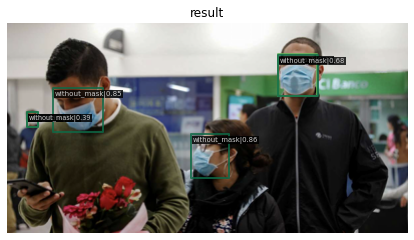

In [56]:
show_result_pyplot(model, img, result)

# Video detection

In [57]:
# video file is saved at /kaggle/working/facemask_detected.mp4
# download this file to watch the video
!python demo/video_demo.py ../../input/face-mask-video/facemask.mp4 ./configs/empirical_attention/faster_rcnn_r50_fpn_attention_0010_dcn_1x_coco.py ./workdirs/epoch_12.pth --out .././facemask_detected.mp4

load checkpoint from local path: ./workdirs/epoch_12.pth
2022-03-21 07:02:19,464 - root - INFO - DeformConv2dPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-03-21 07:02:19,466 - root - INFO - DeformConv2dPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-03-21 07:02:19,467 - root - INFO - DeformConv2dPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-03-21 07:02:19,469 - root - INFO - DeformConv2dPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-03-21 07:02:19,470 - root - INFO - DeformConv2dPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-03-21 07:02:19,473 - root - INFO - DeformConv2dPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-03-21 07:02:19,476 - root - INFO - DeformConv2dPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-03-21 07:02:19,478 - root - INFO - DeformConv2dPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-03-21 07:02:19,481 - root - INFO - DeformConv2dPack backbone.layer3.4.conv2 is upg

# Get locally imported modules

In [58]:
%%writefile .././requirements.txt
writing the requirements here

Writing .././requirements.txt


In [59]:
# stored in the txt file are all of the installed packages in this notebook
!pip freeze > .././requirements.txt